# 2021-11-18 NIH Training - analysing grants data using researchers funding history

Outline 

1. We get all NIH Dimensions identifiers 
2. We explore NIH grants based on chosen set of criteria eg years or keywords, in order to quickly discover trends
3. We analyse who else is funding the NIH-funded researchers 

For more background information, see

* The [grants data model](https://docs.dimensions.ai/dsl/datasource-grants.html)
* The [researchers data model](https://docs.dimensions.ai/dsl/datasource-researchers.html#)
* The [Working with lists in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html) tutorial.


  

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the [API LAB](https://api-lab.dimensions.ai/) *Getting Started* tutorials.


In [ ]:
!pip install dimcli --quiet 

import dimcli
from dimcli.utils import *
c
import json
import sys
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML

import plotly.express as px

print("==\nLogging in..")

ENDPOINT = "https://app.dimensions.ai"

if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login()

dsl = dimcli.Dsl()

## 1. How do I find NIH data using the API ?

In Dimensions, all organizations (including funders) get a unique identifier called a GRID ID. 

The list of NIH directorates GRID identifiers can be easily obtained from [Dimensions](https://app.dimensions.ai/browse/facet-filter-groups/publication/funder_shared_group_facet).

Let's get the GRID IDs and put them into a Python list.

Then we can generate queries programmatically using this list. 

In [2]:
FILE = "http://api-sample-data.dimensions.ai/data/Dimensions-NIH-grid-organizations.csv"
nihgrids = pd.read_csv(FILE)['ID'].to_list()

### Example query: how many grants from the NIH? 

Note the little `json.dumps(nihgrids)` trick to turn a list of Python objects into a string. 



In [3]:
query = f"""
search grants 
    where funders.id in {json.dumps(nihgrids)}
return grants[id+title] limit 1
"""

print("DSL QUERY:\n---\n" + query + "\n---")

grants = dsl.query(query, verbose=True)

DSL QUERY:
---

search grants 
    where funders.id in ["grid.410422.1", "grid.453876.b", "grid.454854.c", "grid.420089.7", "grid.453035.4", "grid.48336.3a", "grid.429651.d", "grid.280655.c", "grid.280030.9", "grid.279885.9", "grid.280128.1", "grid.419681.3", "grid.420086.8", "grid.280347.a", "grid.419633.a", "grid.419635.c", "grid.280664.e", "grid.280785.0", "grid.416868.5", "grid.416870.c", "grid.280738.6", "grid.419475.a", "grid.420085.b", "grid.214431.1", "grid.420090.f", "grid.281076.a", "grid.94365.3d", "grid.410305.3", "grid.453518.e", "grid.436341.7", "grid.453125.4", "grid.280285.5"]
return grants[id+title] limit 1

---
Returned Grants: 1 (total = 476048)
Time: 0.67s


### Is the data correct? A useful strategy 

It's always important to verify the data you have extracted. The Dimensions website can be very useful for that. 

For example, the total number of results above should match [what you see in Dimensions when you search for the NIH 'funder group'](https://app.dimensions.ai/discover/grant?or_facet_funder_shared_group_facet=8dd29b33-9f81-4d6a-afa9-99730d39d9f9) !!

## 2. Extracting NIH researchers (and related organizations)

Now that we have the NIH directorates identifiers, we can use them to pull information about grants and their related researchers. 

Let's use a concrete use case: we want to analyse NIH-funded researchers in the COVID-19 area in the last couple of years.

The following code grabs the top 1000 researchers matching a predefined list of COVID keywords. Researchers are ordered by the tot number of grants they have won. 


In [4]:
COVID_Q = '"2019-nCoV" OR "COVID-19" OR "SARS-CoV-2" OR "HCoV-2019" OR "hcov" OR "NCOVID-19" OR  "severe acute respiratory syndrome coronavirus 2" OR "severe acute respiratory syndrome corona virus 2" OR "coronavirus disease 2019" OR (("coronavirus"  OR "corona virus") AND (Wuhan OR China OR novel))'


query = f'''
search grants 
    for """{COVID_Q}"""
    where funders.id in {json.dumps(nihgrids)}
    and active_year >= 2020
return researchers[id+first_name+last_name+dimensions_url+current_research_org] limit 1000
'''

print(f"Query\n---\n{query}\n---")

researchers = dsl.query(query).as_dataframe()
researchers

Query
---

search grants 
    for """"2019-nCoV" OR "COVID-19" OR "SARS-CoV-2" OR "HCoV-2019" OR "hcov" OR "NCOVID-19" OR  "severe acute respiratory syndrome coronavirus 2" OR "severe acute respiratory syndrome corona virus 2" OR "coronavirus disease 2019" OR (("coronavirus"  OR "corona virus") AND (Wuhan OR China OR novel))"""
    where funders.id in ["grid.410422.1", "grid.453876.b", "grid.454854.c", "grid.420089.7", "grid.453035.4", "grid.48336.3a", "grid.429651.d", "grid.280655.c", "grid.280030.9", "grid.279885.9", "grid.280128.1", "grid.419681.3", "grid.420086.8", "grid.280347.a", "grid.419633.a", "grid.419635.c", "grid.280664.e", "grid.280785.0", "grid.416868.5", "grid.416870.c", "grid.280738.6", "grid.419475.a", "grid.420085.b", "grid.214431.1", "grid.420090.f", "grid.281076.a", "grid.94365.3d", "grid.410305.3", "grid.453518.e", "grid.436341.7", "grid.453125.4", "grid.280285.5"]
    and active_year >= 2020
return researchers[id+first_name+last_name+dimensions_url+current_researc

,count,current_research_org,dimensions_url,first_name,id,last_name
0,8,grid.10698.36,https://app.dimensions.ai/discover/publication...,Ralph Steven,ur.016314333017.37,Baric
1,5,grid.250415.7,https://app.dimensions.ai/discover/publication...,Lan-Ying,ur.01062044220.77,Du
2,5,grid.27873.39,https://app.dimensions.ai/discover/publication...,Thomas L,ur.01253321507.46,Rudge
3,5,grid.419407.f,https://app.dimensions.ai/discover/publication...,Leonard,ur.015766321623.79,Freedman
4,5,grid.419407.f,https://app.dimensions.ai/discover/publication...,Beth R,ur.07545772505.38,Baseler
...,...,...,...,...,...,...
995,1,NaN,https://app.dimensions.ai/discover/publication...,James P,ur.01333015172.88,Gibbs
996,1,grid.266539.d,https://app.dimensions.ai/discover/publication...,Tyrone Finley,ur.01333211447.09,Borders
997,1,grid.185648.6,https://app.dimensions.ai/discover/publication...,Molly A,ur.01333213051.13,Martin
998,1,grid.34477.33,https://app.dimensions.ai/discover/publication...,William Allen,ur.01333450725.21,Banks


### Now that we have the query, we can experiment with other facets..

**Top organizations**

Change the final query bit to `return research_orgs`

In [5]:
%%dsldf 

search grants 
    for "\"2019-nCoV\" OR \"COVID-19\" OR \"SARS-CoV-2\" OR \"HCoV-2019\" OR \"hcov\" OR \"NCOVID-19\" OR  \"severe acute respiratory syndrome coronavirus 2\" OR \"severe acute respiratory syndrome corona virus 2\" OR \"coronavirus disease 2019\" OR ((\"coronavirus\"  OR \"corona virus\") AND (Wuhan OR China OR novel))"
    where funders.id in ["grid.410422.1", "grid.453876.b", "grid.454854.c", "grid.420089.7", "grid.453035.4", "grid.48336.3a", "grid.429651.d", "grid.280655.c", "grid.280030.9", "grid.279885.9", "grid.280128.1", "grid.419681.3", "grid.420086.8", "grid.280347.a", "grid.419633.a", "grid.419635.c", "grid.280664.e", "grid.280785.0", "grid.416868.5", "grid.416870.c", "grid.280738.6", "grid.419475.a", "grid.420085.b", "grid.214431.1", "grid.420090.f", "grid.281076.a", "grid.94365.3d", "grid.410305.3", "grid.453518.e", "grid.436341.7", "grid.453125.4", "grid.280285.5"]
    and active_year >= 2020
return research_orgs limit 1000

Returned Research_orgs: 336
Time: 0.82s


,acronym,city_name,count,country_name,id,latitude,linkout,longitude,name,state_name,types
0,JHU,Baltimore,29,United States,grid.21107.35,39.328888,[https://www.jhu.edu/],-76.620280,Johns Hopkins University,Maryland,[Education]
1,NaN,New York,23,United States,grid.413734.6,40.842750,[http://nyp.org/],-73.943750,NewYork–Presbyterian Hospital,New York,[Healthcare]
2,NaN,Durham,21,United States,grid.26009.3d,36.003147,[http://www.duke.edu/],-78.926895,Duke University,North Carolina,[Education]
3,UCLA,Los Angeles,19,United States,grid.19006.3e,34.072224,[http://www.ucla.edu/],-118.444100,"University of California, Los Angeles",California,[Education]
4,UNC,Chapel Hill,18,United States,grid.10698.36,35.905163,[http://www.unc.edu/],-79.046940,University of North Carolina at Chapel Hill,North Carolina,[Education]
...,...,...,...,...,...,...,...,...,...,...,...
331,OSU,Stillwater,1,United States,grid.65519.3e,36.132220,[http://go.okstate.edu/],-97.080830,Oklahoma State University,Oklahoma,[Education]
332,UCT,Rondebosch,1,South Africa,grid.7836.a,-33.957500,[http://www.uct.ac.za/],18.460556,University of Cape Town,NaN,[Education]
333,IAS,Princeton,1,United States,grid.78989.37,40.331670,[https://www.ias.edu/],-74.667780,Institute for Advanced Study,New Jersey,[Facility]
334,MSM,Atlanta,1,United States,grid.9001.8,33.743000,[http://www.msm.edu/],-84.412000,Morehouse School of Medicine,Georgia,[Education]


**Top Countries**

Change the last query bit to `return research_org_countries`

In [6]:
%%dsldf

search grants 
    for "\"2019-nCoV\" OR \"COVID-19\" OR \"SARS-CoV-2\" OR \"HCoV-2019\" OR \"hcov\" OR \"NCOVID-19\" OR  \"severe acute respiratory syndrome coronavirus 2\" OR \"severe acute respiratory syndrome corona virus 2\" OR \"coronavirus disease 2019\" OR ((\"coronavirus\"  OR \"corona virus\") AND (Wuhan OR China OR novel))"
    where funders.id in ["grid.410422.1", "grid.453876.b", "grid.454854.c", "grid.420089.7", "grid.453035.4", "grid.48336.3a", "grid.429651.d", "grid.280655.c", "grid.280030.9", "grid.279885.9", "grid.280128.1", "grid.419681.3", "grid.420086.8", "grid.280347.a", "grid.419633.a", "grid.419635.c", "grid.280664.e", "grid.280785.0", "grid.416868.5", "grid.416870.c", "grid.280738.6", "grid.419475.a", "grid.420085.b", "grid.214431.1", "grid.420090.f", "grid.281076.a", "grid.94365.3d", "grid.410305.3", "grid.453518.e", "grid.436341.7", "grid.453125.4", "grid.280285.5"]
    and active_year >= 2020
return research_org_countries limit 1000

Returned Research_org_countries: 9
Time: 0.58s


,count,id,name
0,1135,US,United States
1,3,CA,Canada
2,1,CH,Switzerland
3,1,MG,Madagascar
4,1,MY,Malaysia
5,1,NG,Nigeria
6,1,PE,Peru
7,1,ZA,South Africa
8,1,ZM,Zambia


**Who is getting funded outside the US?**

Use the filter `research_org_countries.name != "United States"`

In [7]:
%%dsldf 

search grants 
    for "\"2019-nCoV\" OR \"COVID-19\" OR \"SARS-CoV-2\" OR \"HCoV-2019\" OR \"hcov\" OR \"NCOVID-19\" OR  \"severe acute respiratory syndrome coronavirus 2\" OR \"severe acute respiratory syndrome corona virus 2\" OR \"coronavirus disease 2019\" OR ((\"coronavirus\"  OR \"corona virus\") AND (Wuhan OR China OR novel))"
    where funders.id in ["grid.410422.1", "grid.453876.b", "grid.454854.c", "grid.420089.7", "grid.453035.4", "grid.48336.3a", "grid.429651.d", "grid.280655.c", "grid.280030.9", "grid.279885.9", "grid.280128.1", "grid.419681.3", "grid.420086.8", "grid.280347.a", "grid.419633.a", "grid.419635.c", "grid.280664.e", "grid.280785.0", "grid.416868.5", "grid.416870.c", "grid.280738.6", "grid.419475.a", "grid.420085.b", "grid.214431.1", "grid.420090.f", "grid.281076.a", "grid.94365.3d", "grid.410305.3", "grid.453518.e", "grid.436341.7", "grid.453125.4", "grid.280285.5"]
    and active_year >= 2020
    and research_org_countries.name != "United States"
return research_orgs limit 1000




Returned Research_orgs: 9
Time: 2.39s


,acronym,city_name,count,country_name,id,latitude,linkout,longitude,name,types,state_name
0,UPCH,Lima,1,Peru,grid.11100.31,-12.023458,[http://www.upch.edu.pe/portal/],-77.056790,Cayetano Heredia University,[Education],NaN
1,NaN,Toronto,1,Canada,grid.17063.33,43.661667,[http://www.utoronto.ca/],-79.395000,University of Toronto,[Education],Ontario
2,UBC,Vancouver,1,Canada,grid.17091.3e,49.260674,[https://www.ubc.ca/],-123.246080,University of British Columbia,[Education],British Columbia
3,CIDRZ,Lusaka,1,Zambia,grid.418015.9,-15.393451,[http://www.cidrz.org/],28.321096,Centre for Infectious Disease Research in Zambia,[Nonprofit],NaN
4,IMP,Antananarivo,1,Madagascar,grid.418511.8,-18.902609,[http://www.pasteur.mg/],47.546270,Institut Pasteur de Madagascar,[Nonprofit],NaN
5,IHVN,Abuja,1,Nigeria,grid.421160.0,9.053575,[http://ihvnigeria.org/ihvnweb/webnew/],7.485247,Institute of Human Virology,[Government],NaN
6,UB,Bern,1,Switzerland,grid.5734.5,46.950520,[http://www.unibe.ch/eng/],7.438109,University of Bern,[Education],NaN
7,SFU,Burnaby,1,Canada,grid.61971.38,49.278282,[http://www.sfu.ca/],-122.919910,Simon Fraser University,[Education],British Columbia
8,UCT,Rondebosch,1,South Africa,grid.7836.a,-33.957500,[http://www.uct.ac.za/],18.460556,University of Cape Town,[Education],NaN


**How do I see the specific grants information?**

Eg if I want to follow up on those non-US grants

In [8]:
df = dsl.query('''
search grants 
    for """\"2019-nCoV\" OR \"COVID-19\" OR \"SARS-CoV-2\" OR \"HCoV-2019\" OR \"hcov\" OR \"NCOVID-19\" OR  \"severe acute respiratory syndrome coronavirus 2\" OR \"severe acute respiratory syndrome corona virus 2\" OR \"coronavirus disease 2019\" OR ((\"coronavirus\"  OR \"corona virus\") AND (Wuhan OR China OR novel))"""
    where funders.id in ["grid.410422.1", "grid.453876.b", "grid.454854.c", "grid.420089.7", "grid.453035.4", "grid.48336.3a", "grid.429651.d", "grid.280655.c", "grid.280030.9", "grid.279885.9", "grid.280128.1", "grid.419681.3", "grid.420086.8", "grid.280347.a", "grid.419633.a", "grid.419635.c", "grid.280664.e", "grid.280785.0", "grid.416868.5", "grid.416870.c", "grid.280738.6", "grid.419475.a", "grid.420085.b", "grid.214431.1", "grid.420090.f", "grid.281076.a", "grid.94365.3d", "grid.410305.3", "grid.453518.e", "grid.436341.7", "grid.453125.4", "grid.280285.5"]
    and active_year >= 2020
    and research_org_countries.name != "United States"
return grants[id+dimensions_url+active_year+funding_org_name+funding_usd+grant_number+title+unnest(research_org_countries)+unnest(research_org_names)] limit 1000
'''
).as_dataframe()



Returned objects: 10 (total grants= 10)
Time: 0.56s


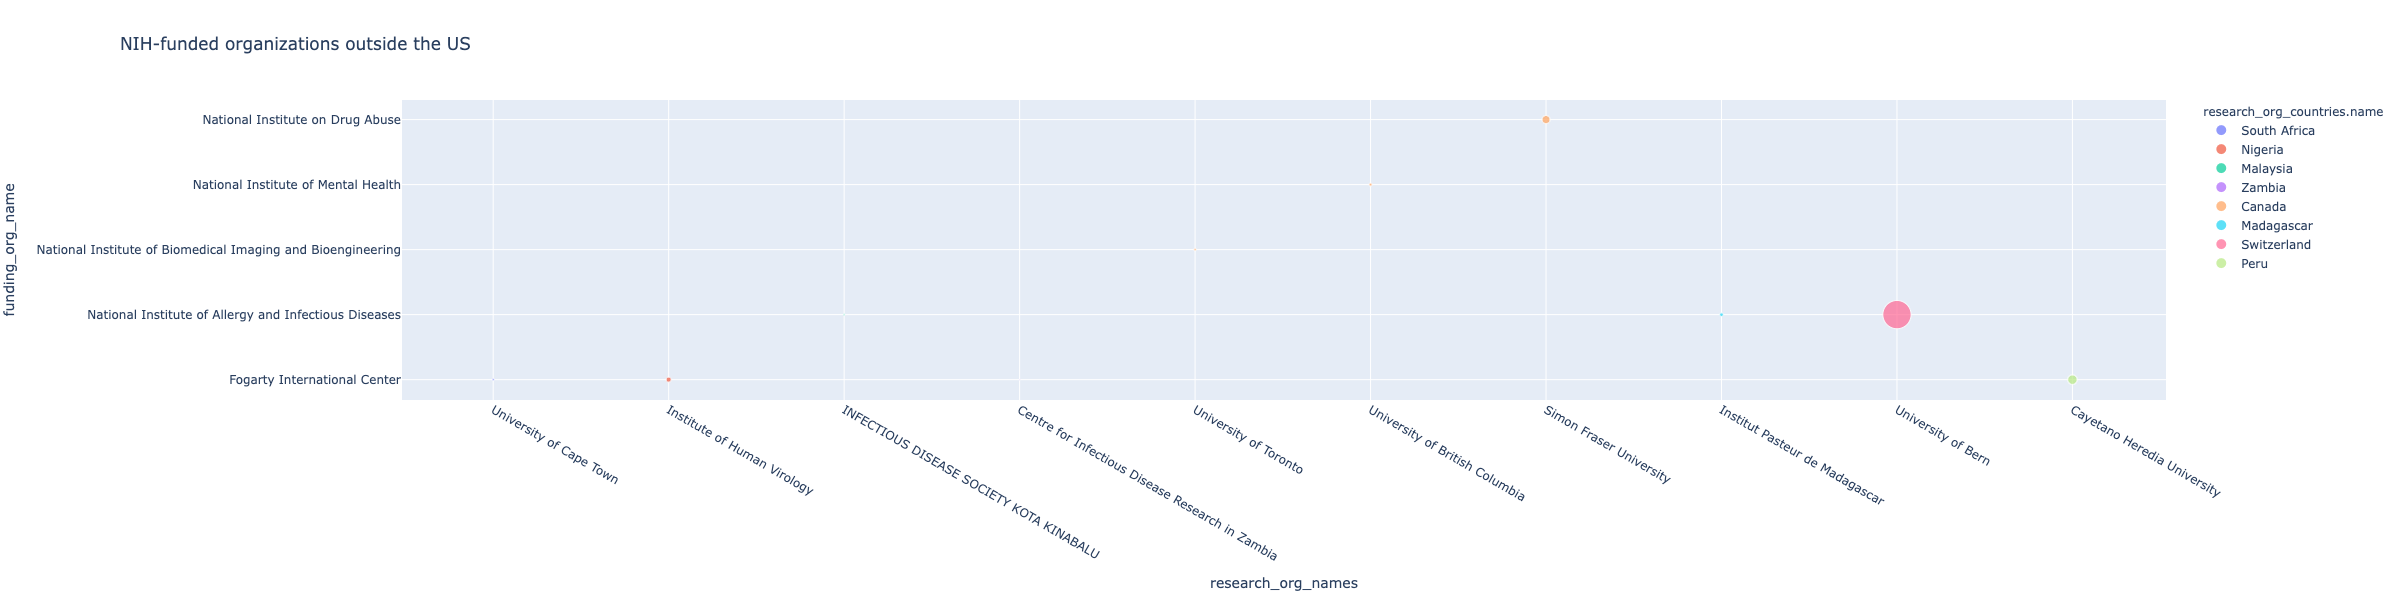

In [18]:
px.scatter(df, y="funding_org_name", 
               x="research_org_names", 
              color="research_org_countries.name", 
              size="funding_usd", 
              height=600,
              title="NIH-funded organizations outside the US")

## 2. Researchers associations

> What are known foreign associations of NIH funded researchers? E.g., collaborators on pubs or patents, organizational or funding associations. 

In [10]:
# reusing the researchers list we created above
researchers

,count,current_research_org,dimensions_url,first_name,id,last_name
0,8,grid.10698.36,https://app.dimensions.ai/discover/publication...,Ralph Steven,ur.016314333017.37,Baric
1,5,grid.250415.7,https://app.dimensions.ai/discover/publication...,Lan-Ying,ur.01062044220.77,Du
2,5,grid.27873.39,https://app.dimensions.ai/discover/publication...,Thomas L,ur.01253321507.46,Rudge
3,5,grid.419407.f,https://app.dimensions.ai/discover/publication...,Leonard,ur.015766321623.79,Freedman
4,5,grid.419407.f,https://app.dimensions.ai/discover/publication...,Beth R,ur.07545772505.38,Baseler
...,...,...,...,...,...,...
995,1,NaN,https://app.dimensions.ai/discover/publication...,James P,ur.01333015172.88,Gibbs
996,1,grid.266539.d,https://app.dimensions.ai/discover/publication...,Tyrone Finley,ur.01333211447.09,Borders
997,1,grid.185648.6,https://app.dimensions.ai/discover/publication...,Molly A,ur.01333213051.13,Martin
998,1,grid.34477.33,https://app.dimensions.ai/discover/publication...,William Allen,ur.01333450725.21,Banks


### Who else is funding these researchers?

Steps

* Extract all grants related to these researchers, in the last 10 years
* Analyse the grants data eg by funder, by country, or by awardees  

Let's review the API data model to understand what relationships are available:

In [11]:
Image(url= "https://docs.dimensions.ai/dsl/_images/data-model-grants.png", width=600)

In [12]:
# we get grants for all researchers, by segmenting the researchers list into groups of 300 IDs
# this is because each DSL query can take max ~300 researchers at a time 

from tqdm.notebook import tqdm as progressbar
researcher_ids = researchers['id'].to_list()

#
# TRIAL RUN: Uncomment this line to use less researchers and speed things up
#
# researcher_ids= researcher_ids[:200]


#
# the main API query
#
q = """search grants
          where researchers in {}
       return grants[id+dimensions_url+researchers+title+active_year+funding_usd+funding_org_name+unnest(funder_countries)+unnest(research_org_countries)+unnest(research_org_names)]"""


#
# let's loop through all researcher IDs in chunks and query Dimensions
#
results = []
for chunk in progressbar(list(chunks_of(list(researcher_ids), 200))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=True)
    results += data.grants
    time.sleep(1)

#
# put the data into a dataframe, remove duplicates and save
#
grants = pd.DataFrame().from_dict(results)
print("Grants: ", len(grants))
grants.drop_duplicates(subset='id', inplace=True)
print("Unique Grants: ", len(grants))

#
# preview
#
print("Example:")
grants.head(5)

  0%|          | 0/5 [00:00<?, ?it/s]

Starting iteration with limit=1000 skip=0 ...
0-1000 / 2640 (2.52s)
1000-2000 / 2640 (3.36s)
2000-2640 / 2640 (4.07s)
2640-2640 / 2640 (0.53s)
===
Records extracted: 8983
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1778 (2.32s)
1000-1778 / 1778 (4.27s)
1778-1778 / 1778 (0.49s)
===
Records extracted: 3030
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1673 (2.34s)
1000-1673 / 1673 (4.11s)
1673-1673 / 1673 (0.54s)
===
Records extracted: 4251
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1773 (1.25s)
1000-1773 / 1773 (4.09s)
1773-1773 / 1773 (0.58s)
===
Records extracted: 2995
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1632 (1.15s)
1000-1632 / 1632 (1.82s)
1632-1632 / 1632 (0.55s)
===
Records extracted: 2618


Grants:  21877
Unique Grants:  9074
Example:


,active_year,dimensions_url,funder_countries.id,funder_countries.name,funding_org_name,funding_usd,id,research_org_countries.id,research_org_countries.name,research_org_names,researchers,title
0,"[2021, 2022, 2023, 2024]",https://app.dimensions.ai/details/grant/grant....,US,United States,Congressionally Directed Medical Research Prog...,2345195.0,grant.9843026,US,United States,Gladstone Institutes,"[{'first_name': 'Leor S', 'id': 'ur.0103733410...",Phase 1 Clinical Trial for Therapeutic Interve...
1,"[2021, 2022, 2023, 2024]",https://app.dimensions.ai/details/grant/grant....,US,United States,National Heart Lung and Blood Institute,2615479.0,grant.9845908,US,United States,University of North Dakota,"[{'first_name': 'Abraam M', 'id': 'ur.01040052...",SARS-CoV-2 tropism in the brain and its relati...
2,"[2021, 2022, 2023]",https://app.dimensions.ai/details/grant/grant....,US,United States,National Institute of Allergy and Infectious D...,231250.0,grant.9846682,US,United States,University of Kansas Medical Center,"[{'first_name': 'Jianming', 'id': 'ur.01002513...",Identification of the AAVR-independent AAV ent...
3,"[2021, 2022, 2023, 2024]",https://app.dimensions.ai/details/grant/grant....,US,United States,National Institute of Allergy and Infectious D...,2820494.0,grant.9844836,US,United States,"VXBIOSCIENCES, INC.","[{'first_name': 'Leor S', 'id': 'ur.0103733410...","Autonomously deploying, co-evolving SARS-CoV-2..."
4,"[2021, 2022, 2023, 2024, 2025, 2026]",https://app.dimensions.ai/details/grant/grant....,US,United States,Office of the Director,1977596.0,grant.9848803,US,United States,City University of New York,"[{'first_name': 'Victoria Khanh', 'id': 'ur.01...",Harlem Strong Mental Health Coalition: A Multi...


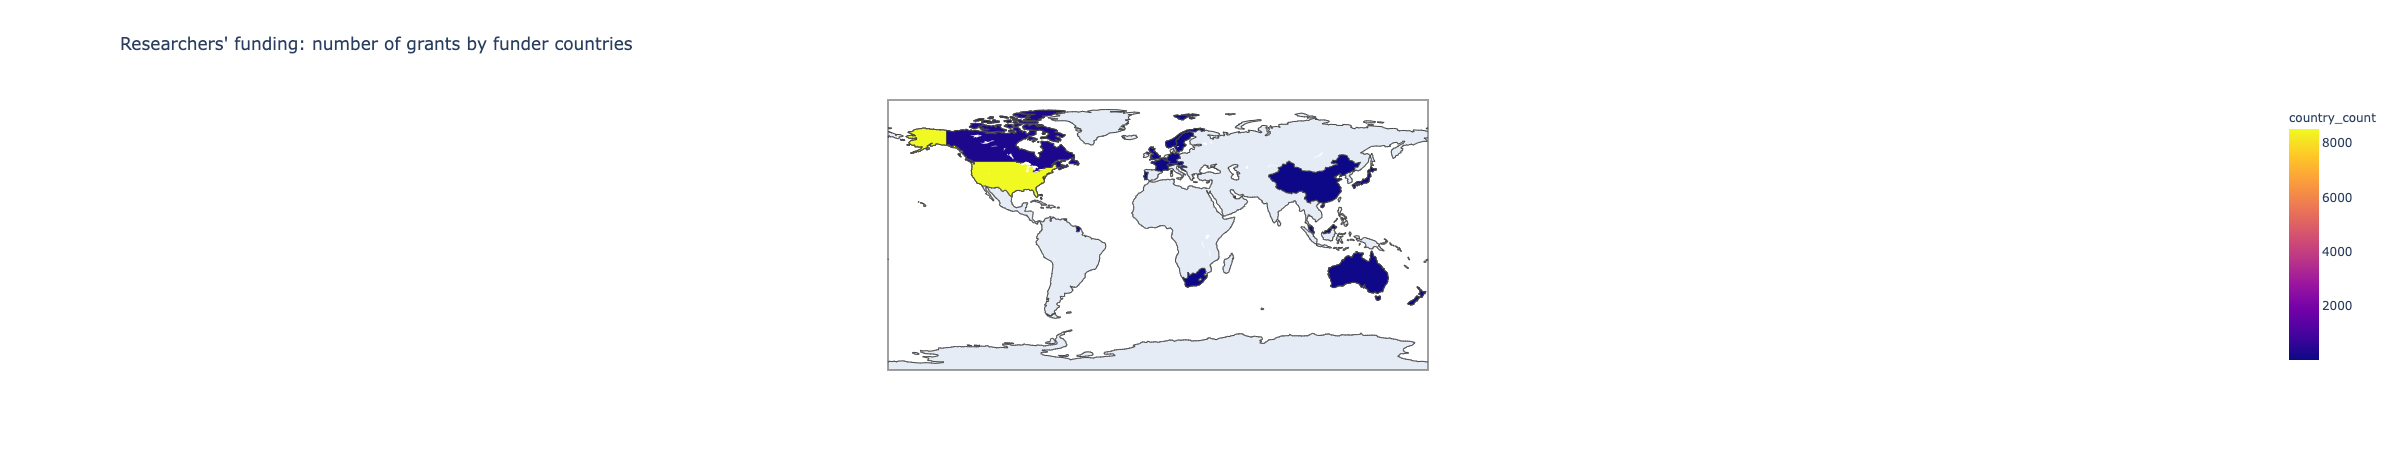

In [19]:
# fix empty values
grants.fillna(0, inplace=True) 
# add aggregated counts
grants['country_count'] = grants.groupby('funder_countries.name')['id'].transform('count')
grants['country_funding'] = grants.groupby('funder_countries.name')['funding_usd'].transform('sum')

gsubset = grants[['funder_countries.name', 'country_count']]
px.choropleth(gsubset.drop_duplicates(), 
                  locations="funder_countries.name",
                  locationmode="country names",
                  color="country_count", 
                  hover_name="funder_countries.name",
                  color_continuous_scale=px.colors.sequential.Plasma,
                  title="Researchers' funding: number of grants by funder countries")

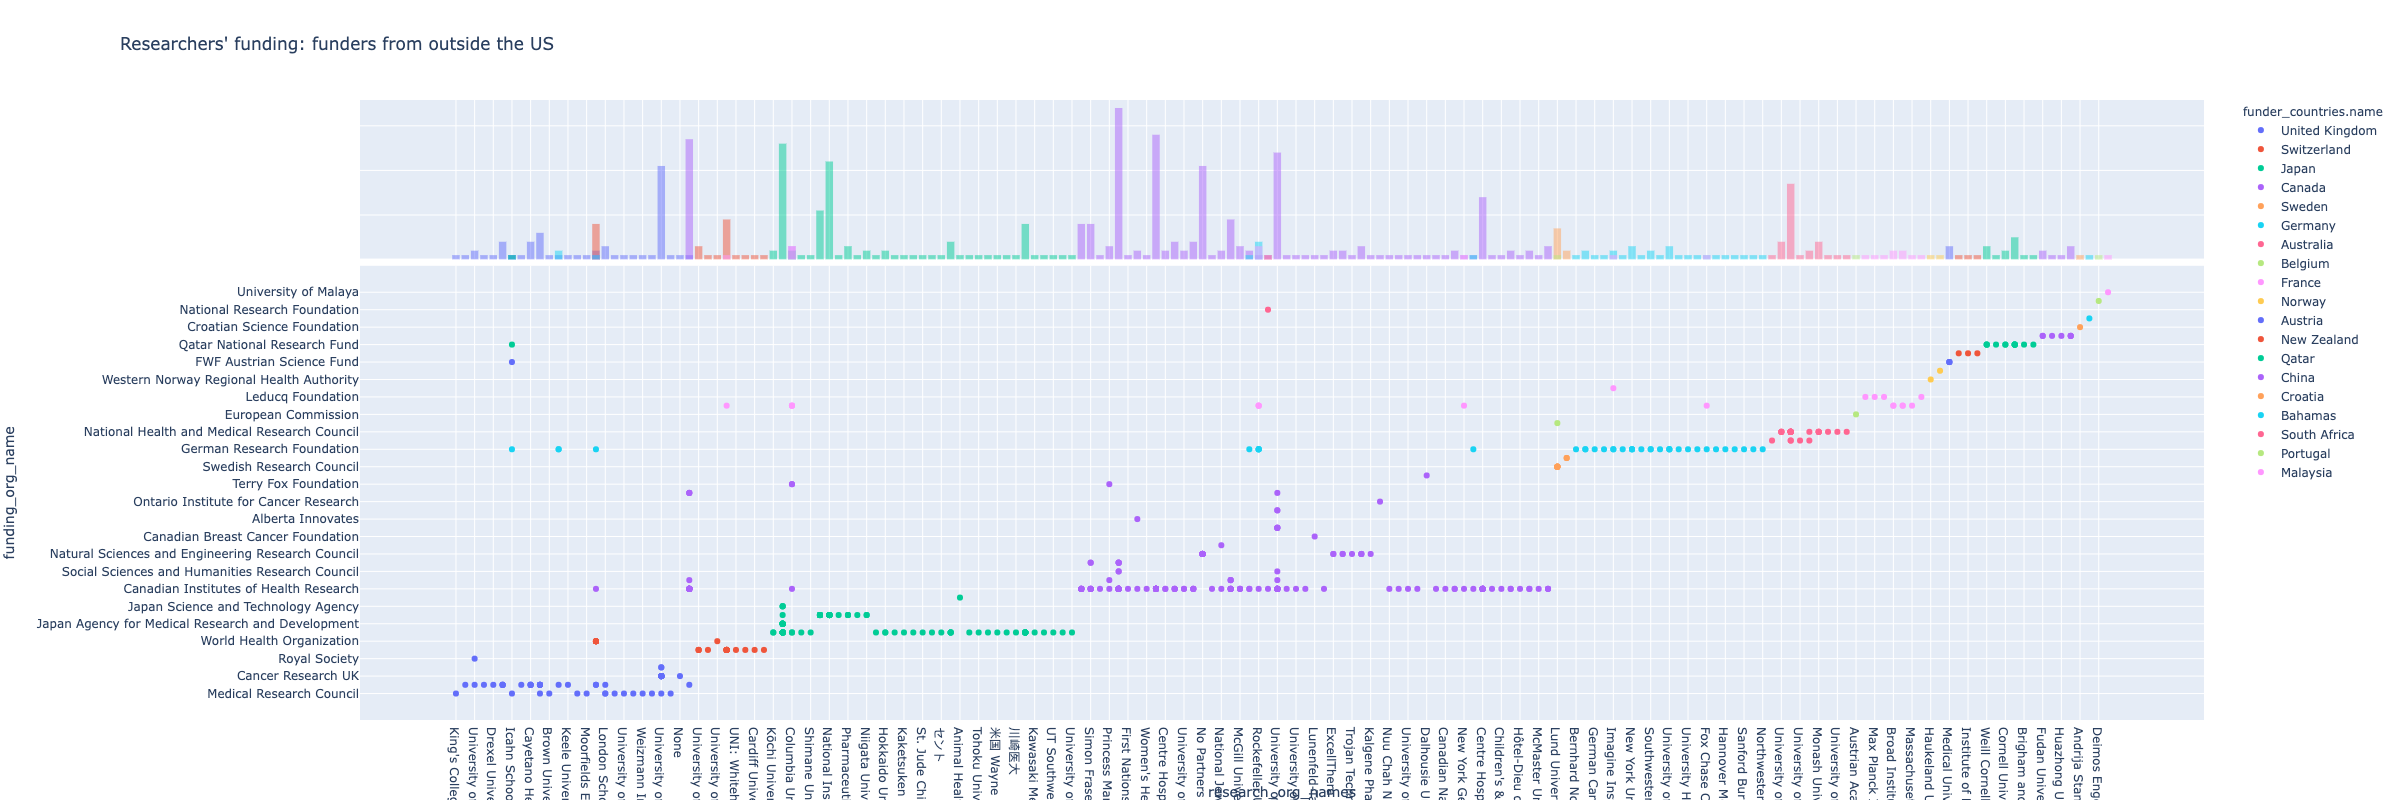

In [20]:
gsubset = grants[grants["funder_countries.name"] != 'United States']

px.scatter(gsubset,
           y="funding_org_name", 
           x="research_org_names", 
           marginal_x="histogram",
           color="funder_countries.name", 
           height=800,
           title="Researchers' funding: funders from outside the US")

**To view the grants details**

In [15]:
grants[grants["funder_countries.name"] == 'Japan'].head()

,active_year,dimensions_url,funder_countries.id,funder_countries.name,funding_org_name,funding_usd,id,research_org_countries.id,research_org_countries.name,research_org_names,researchers,title,country_count,country_funding
239,"[2021, 2022]",https://app.dimensions.ai/details/grant/grant....,JP,Japan,Japan Society for the Promotion of Science,37711.0,grant.9670570,JP,Japan,Kōchi University,"[{'first_name': 'Yoshihiro', 'id': 'ur.0126107...",Neo virology: the headwaters from the superorg...,105,73486106.0
684,"[2020, 2021, 2022, 2023]",https://app.dimensions.ai/details/grant/grant....,JP,Japan,Japan Agency for Medical Research and Development,0.0,grant.9618136,JP,Japan,University of Tokyo,"[{'first_name': 'Yoshihiro', 'id': 'ur.0126107...",Research and development of next-generation va...,105,73486106.0
685,"[2020, 2021]",https://app.dimensions.ai/details/grant/grant....,JP,Japan,Japan Agency for Medical Research and Development,0.0,grant.9617865,JP,Japan,University of Tokyo,"[{'first_name': 'Yoshihiro', 'id': 'ur.0126107...",Development of live attenuated vaccine against...,105,73486106.0
686,"[2020, 2021]",https://app.dimensions.ai/details/grant/grant....,JP,Japan,Japan Agency for Medical Research and Development,0.0,grant.9617655,JP,Japan,University of Tokyo,"[{'first_name': 'Yoshihiro', 'id': 'ur.0126107...",Establishment of treatment for new coronavirus...,105,73486106.0
893,"[2019, 2020, 2021, 2022]",https://app.dimensions.ai/details/grant/grant....,JP,Japan,Japan Agency for Medical Research and Development,455548.0,grant.9618548,JP,Japan,University of Tokyo,"[{'first_name': 'Yoshihiro', 'id': 'ur.0126107...",Creation of a developing chicken egg influenza...,105,73486106.0


**To find out who are the NIH researchers** 

In [16]:
# eg for Japan

COUNTRY = "Japan"

focus_set = grants[grants["funder_countries.name"] == COUNTRY]['researchers'].to_list()

for res in focus_set[0]:
    if res['id'] in researcher_ids:
        print(res['first_name'], res['last_name'], "\n", dimensions_url(res['id'], 'researchers'))

Yoshihiro Kawaoka 
 https://app.dimensions.ai/discover/publication?and_facet_researcher=ur.01261074774.41


## Next steps

* Doing this at scale: see the [Working with lists tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html) that shows how to deal with list of researchers / grants of any size, using pagination and 'chunking' methods
* Makings the analysis more specific by using the [investigators details data structure](https://docs.dimensions.ai/dsl/datasource-grants.html#grants-investigators-long-desc) in the API grants model
* Going from grants to [Related publications](https://api-lab.dimensions.ai/cookbooks/3-grants/2-grants-enrichment-adding-publications-information.html)
* Going from grants to [Related Patents and Clinical Trials](https://api-lab.dimensions.ai/cookbooks/3-grants/3-grants-enrichment-adding-patents-cltrials-information.html)
